In [165]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn import metrics 
from sklearn.svm import SVC  
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.ensemble import RandomForestRegressor 
from datetime import datetime
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import r2_score

import warnings 
warnings.filterwarnings('ignore')


In [166]:
data=pd.read_csv("D:/MIT-WPU/5th sem/ML/Mini project/Dataset/ola.csv")

In [167]:
print('Shape of the data',data.shape)

Shape of the data (10886, 12)


In [168]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [169]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [170]:
print("Statistical Summary of data\n",data.describe().T)

Statistical Summary of data
               count        mean         std   min      25%      50%       75%  \
season      10886.0    2.506614    1.116174  1.00   2.0000    3.000    4.0000   
holiday     10886.0    0.028569    0.166599  0.00   0.0000    0.000    0.0000   
workingday  10886.0    0.680875    0.466159  0.00   0.0000    1.000    1.0000   
weather     10886.0    1.418427    0.633839  1.00   1.0000    1.000    2.0000   
temp        10886.0   20.230860    7.791590  0.82  13.9400   20.500   26.2400   
atemp       10886.0   23.655084    8.474601  0.76  16.6650   24.240   31.0600   
humidity    10886.0   61.886460   19.245033  0.00  47.0000   62.000   77.0000   
windspeed   10886.0   12.799395    8.164537  0.00   7.0015   12.998   16.9979   
casual      10886.0   36.021955   49.960477  0.00   4.0000   17.000   49.0000   
registered  10886.0  155.552177  151.039033  0.00  36.0000  118.000  222.0000   
count       10886.0  191.574132  181.144454  1.00  42.0000  145.000  284.0000   

In [171]:
print('Casual + Registered = Count? ', ~(data.casual + data.registered - data['count']).any())

Casual + Registered = Count?  True


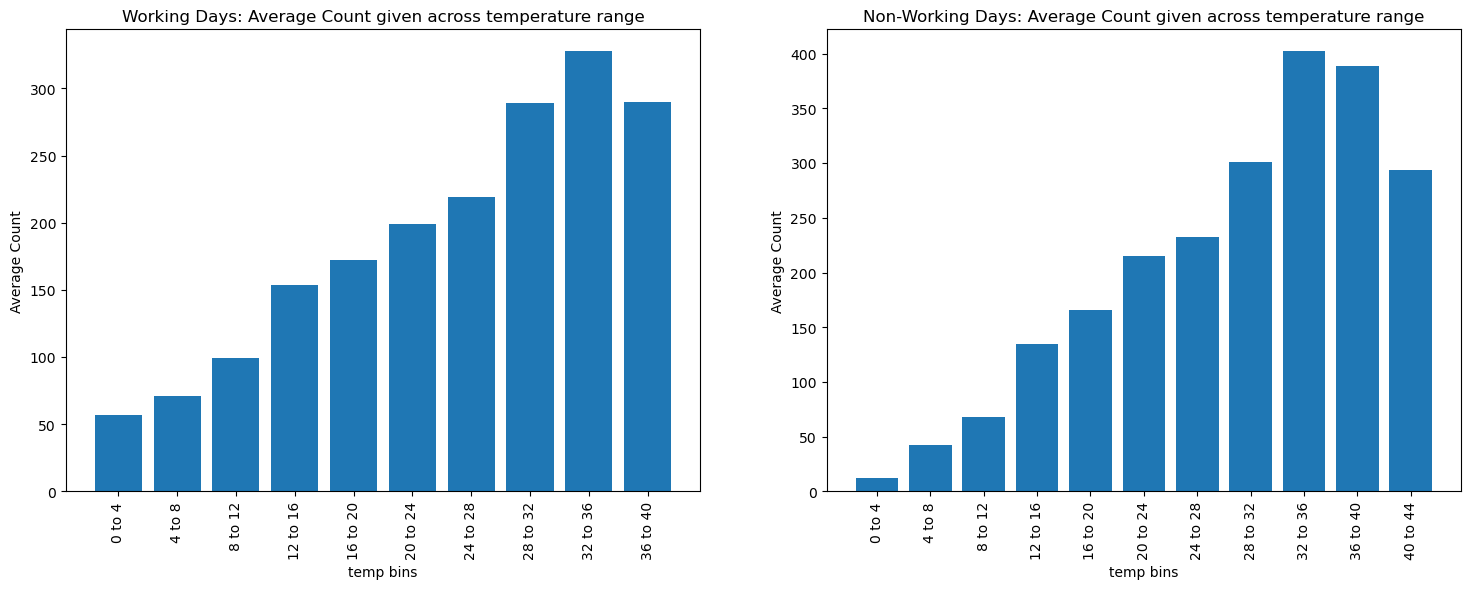

In [172]:
bin_size = 4
data['temp_round'] = (data['temp'] // bin_size) * bin_size

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, working_day in enumerate([1, 0]):
    subset = data[data['workingday'] == working_day]
    mean_count_vs_temp = subset.groupby('temp_round')['count'].mean()
    idx = range(len(mean_count_vs_temp))
    labels = [f'{bin_size * i} to {bin_size * (i + 1)}' for i in range(len(mean_count_vs_temp))]

    axes[i].bar(x=idx, height=mean_count_vs_temp)
    axes[i].set_xticks(idx)
    axes[i].set_xticklabels(labels, rotation=90)
    axes[i].set_xlabel('temp bins')
    axes[i].set_ylabel('Average Count')
    axes[i].set_title(f'{"Working" if working_day else "Non-Working"} Days: Average Count given across temperature range')

plt.show()

FEATURE ENGINEERING

In [173]:
#separated the date and time
parts = data["datetime"].str.split(" ", n=2, expand=True) 
data["date"] = parts[0] 
data["hour"] = parts[1].str[:2].astype('int') 
data.head() 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,temp_round,date,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,8.0,2011-01-01,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,8.0,2011-01-01,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,8.0,2011-01-01,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,8.0,2011-01-01,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,8.0,2011-01-01,4


In [174]:
#extracting day, month, and year from the date column.
parts = data["date"].str.split("-", n=3, expand=True) 
data["day"] = parts[2].astype('int') 
data["month"] = parts[1].astype('int') 
data["year"] = parts[0].astype('int') 
data.head() 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,temp_round,date,hour,day,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,8.0,2011-01-01,0,1,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,8.0,2011-01-01,1,1,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,8.0,2011-01-01,2,1,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,8.0,2011-01-01,3,1,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,8.0,2011-01-01,4,1,1,2011


In [175]:
def weekend_or_weekday(year, month, day): 
    d = datetime(year, month, day) 
    if d.weekday() > 4: 
        return 0
    else: 
        return 1
data['weekday'] = data.apply(lambda x: 
                         weekend_or_weekday(x['year'], 
                                            x['month'], 
                                            x['day']), 
                         axis=1) 
data.head() 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,temp_round,date,hour,day,month,year,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,8.0,2011-01-01,0,1,1,2011,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,8.0,2011-01-01,1,1,1,2011,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,8.0,2011-01-01,2,1,1,2011,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,8.0,2011-01-01,3,1,1,2011,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,8.0,2011-01-01,4,1,1,2011,0


In [176]:
def am_or_pm(x): 
    if x > 11: 
        return 1
    else: 
        return 0
data['am_or_pm'] = data['hour'].apply(am_or_pm) 
data.head() 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,temp_round,date,hour,day,month,year,weekday,am_or_pm
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,8.0,2011-01-01,0,1,1,2011,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,8.0,2011-01-01,1,1,1,2011,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,8.0,2011-01-01,2,1,1,2011,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,8.0,2011-01-01,3,1,1,2011,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,8.0,2011-01-01,4,1,1,2011,0,0


In [177]:
import holidays   
def is_holiday(x): 
    india_holidays = holidays.country_holidays('IN') 
    if india_holidays.get(x): 
        return 1
    else: 
        return 0
data['holidays'] = data['date'].apply(is_holiday) 
data.head() 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,temp_round,date,hour,day,month,year,weekday,am_or_pm,holidays
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,16,8.0,2011-01-01,0,1,1,2011,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,40,8.0,2011-01-01,1,1,1,2011,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,32,8.0,2011-01-01,2,1,1,2011,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,13,8.0,2011-01-01,3,1,1,2011,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,1,8.0,2011-01-01,4,1,1,2011,0,0,0


Removing columns which are not useful

In [178]:
data.drop(['datetime', 'date','atemp'], 
        axis=1, 
        inplace=True) 

Exploratory Data Analysis

In [132]:
data.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
humidity      0
windspeed     0
casual        0
registered    0
count         0
temp_round    0
hour          0
day           0
month         0
year          0
weekday       0
am_or_pm      0
holidays      0
dtype: int64

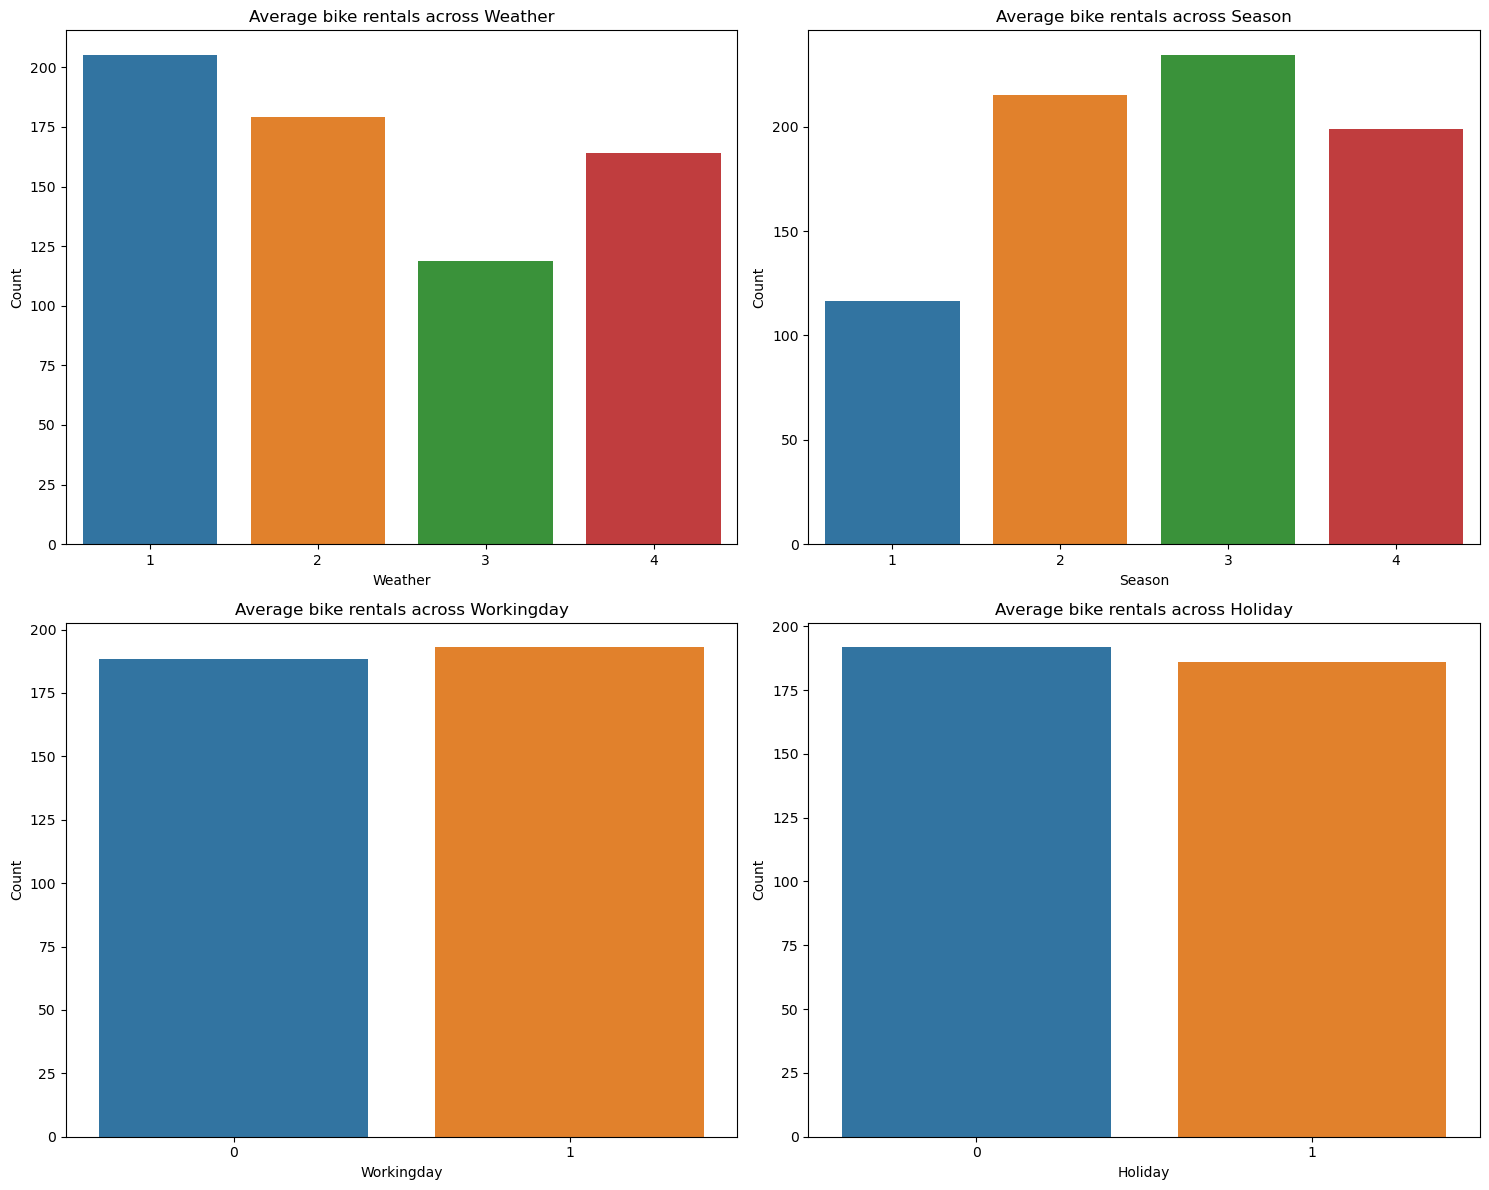

In [133]:
categorical_columns = ['weather', 'season', 'workingday', 'holiday']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, col in enumerate(categorical_columns):
    group_data = data.groupby([col])['count'].mean().reset_index()
    
    sns.barplot(data=group_data, x=col, y='count', ax=axes[i // 2, i % 2])
    
    axes[i // 2, i % 2].set(xlabel=col.capitalize(), ylabel='Count', title=f'Average bike rentals across {col.capitalize()}')
plt.tight_layout()
plt.show()

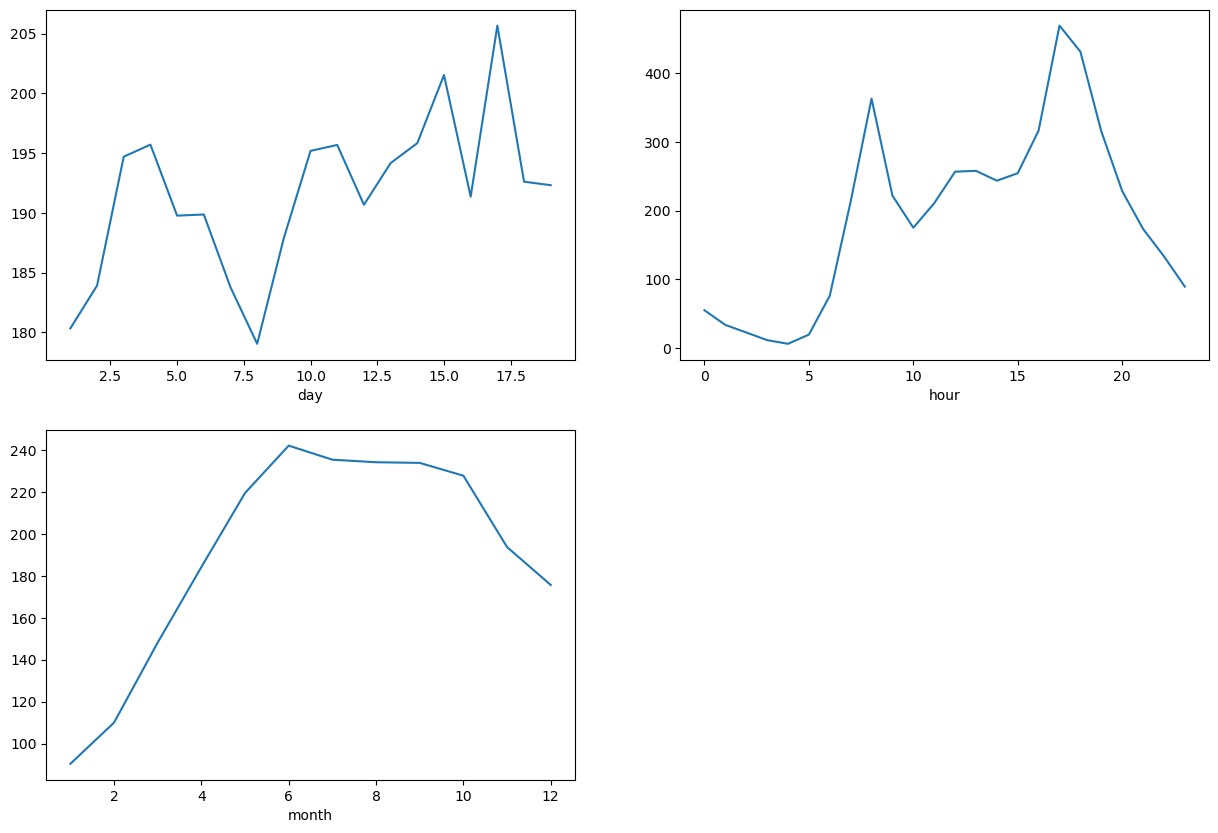

In [134]:
features = ['day', 'hour', 'month'] 
plt.subplots(figsize=(15, 10)) 
for i, col in enumerate(features): 
    plt.subplot(2, 2, i + 1) 
    data.groupby(col).mean()['count'].plot() 
plt.show() 

OBSERVATIONS:

-There is no such pattern in the day-wise average of the ride requests.

-More ride requests in the working hours as compared to the non-working hours.

-The average ride request count has dropped in the month of festivals that is after the 7th month that is July that is due to more holidays in these months.

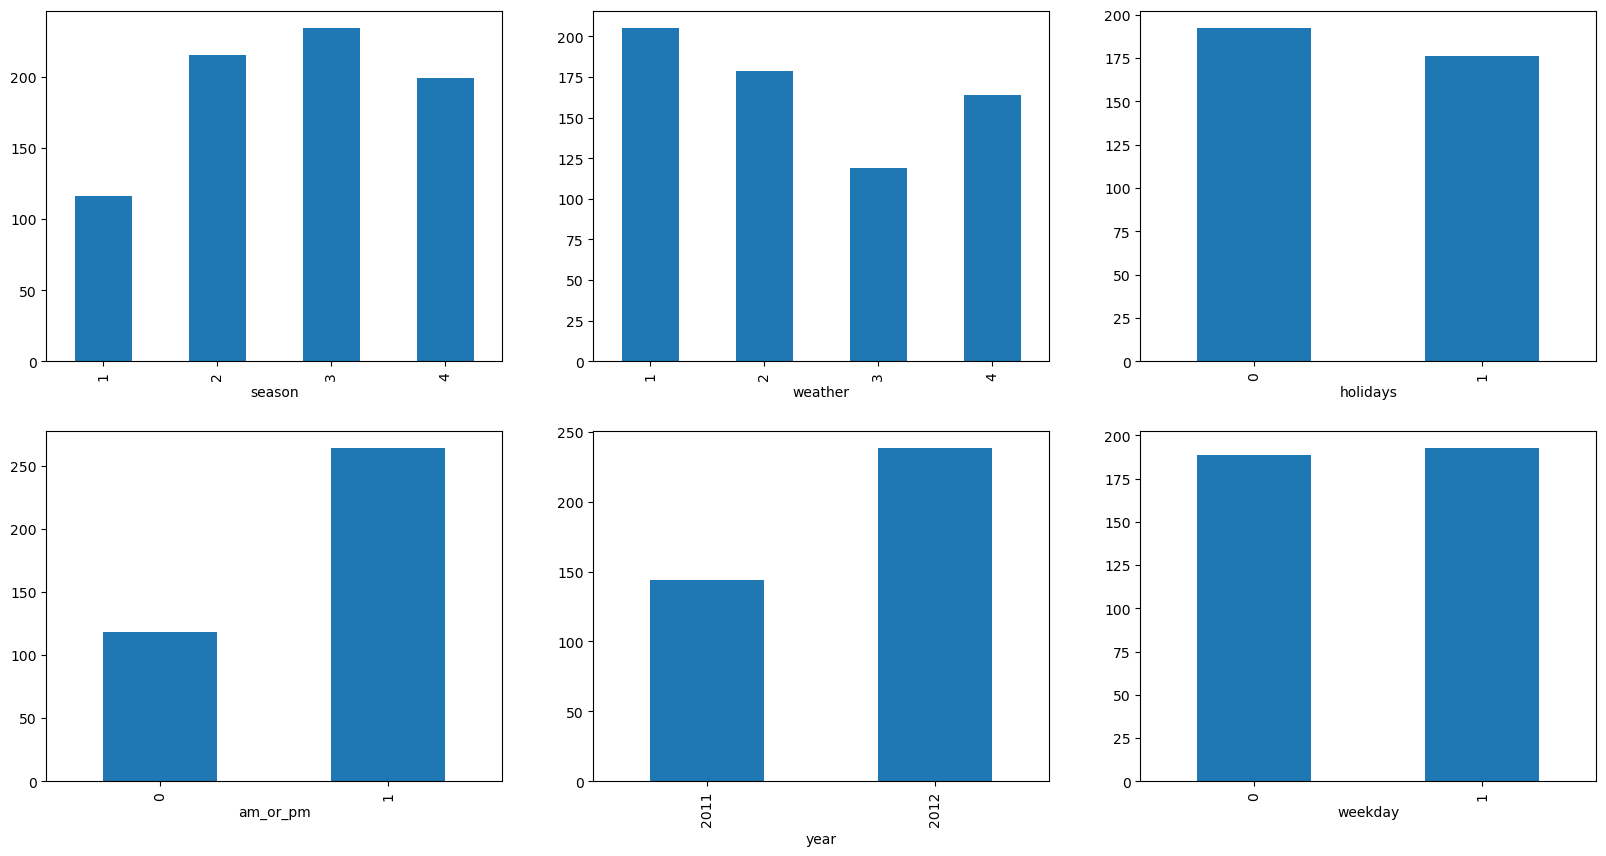

In [135]:
features = ['season', 'weather', 'holidays','am_or_pm', 'year', 'weekday'] 
plt.subplots(figsize=(20, 10)) 
for i, col in enumerate(features): 
    plt.subplot(2, 3, i + 1) 
    data.groupby(col).mean()['count'].plot.bar() 
plt.show()

OBSERVATIONS:

-Ride request demand is high in the summer as well as season.

-The third category was extreme weather conditions due to this people avoid taking bike rides and like to stay safe at home.

-More ride requests during working hours as compared to non-working hours.

-Bike ride requests have increased significantly from the year 2011 to the year 2012.

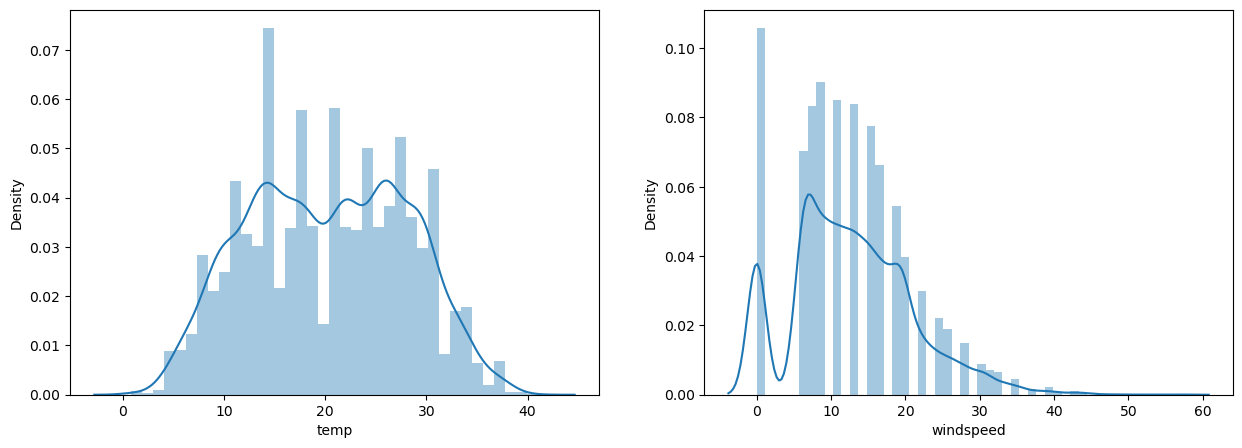

In [136]:
features = ['temp', 'windspeed']  
plt.subplots(figsize=(15, 5)) 
for i, col in enumerate(features): 
  plt.subplot(1, 2, i + 1) 
  sns.distplot(data[col]) 
plt.show()

Temperature values are normally distributed but due to the high number of 0 entries in the windspeed column, the data distribution shows some irregularities.

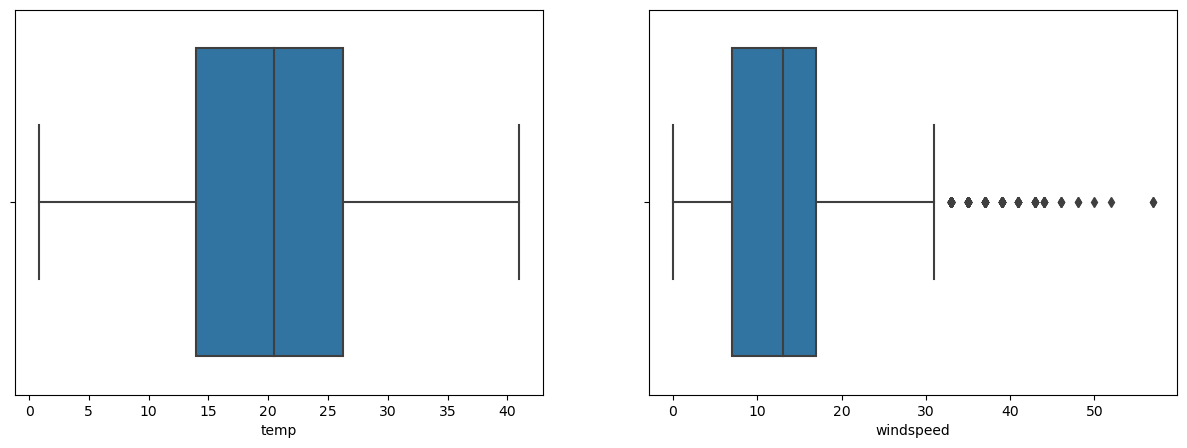

In [137]:
#outliers
features = ['temp', 'windspeed']   
plt.subplots(figsize=(15, 5)) 
for i, col in enumerate(features): 
  plt.subplot(1, 2, i + 1) 
  sns.boxplot(data[col]) 
plt.show()

In [138]:
num_rows = data.shape[0] - data[data['windspeed']<32].shape[0] 
print(f'Number of rows that will be lost if we remove outliers is equal to {num_rows}.')

Number of rows that will be lost if we remove outliers is equal to 227.


There are total 10000 rows so 227 rows won't affect the learning for model

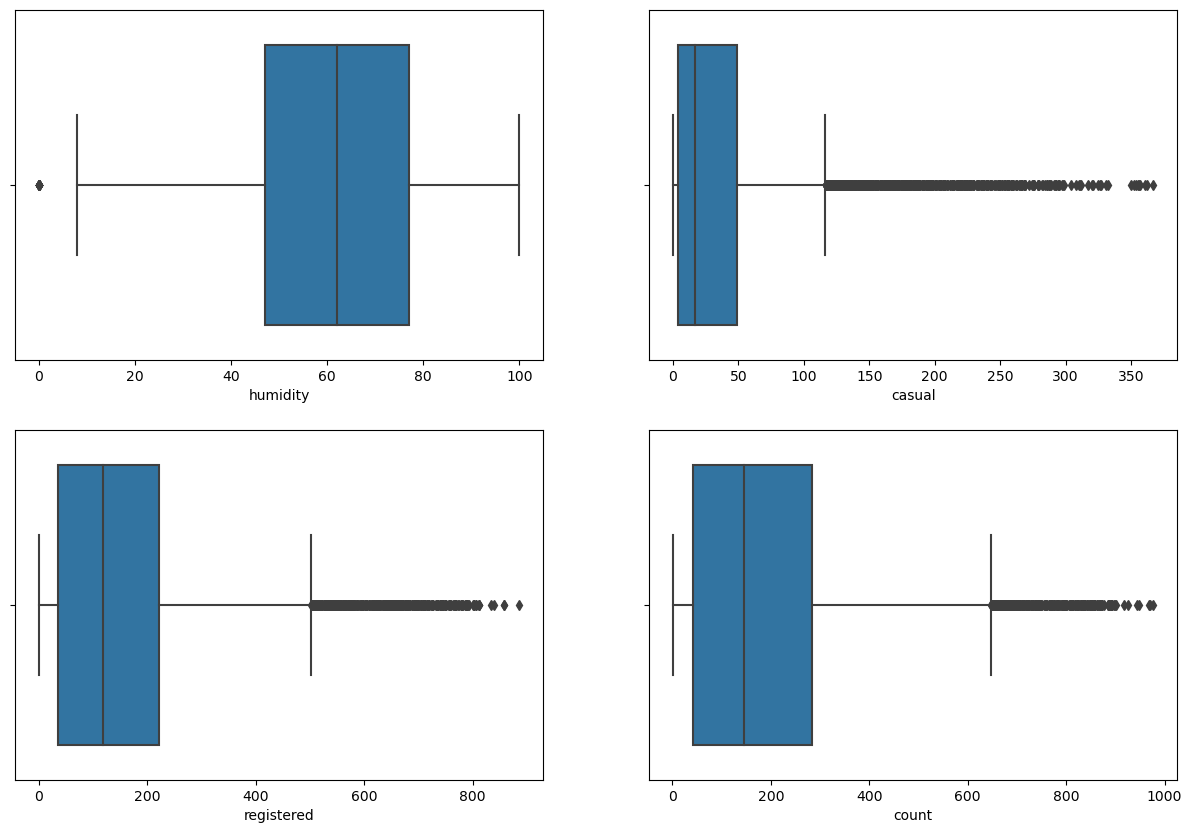

In [139]:
features = ['humidity', 'casual', 'registered', 'count'] 
plt.subplots(figsize=(15, 10)) 
for i, col in enumerate(features): 
    plt.subplot(2, 2, i + 1) 
    sns.boxplot(data[col]) 
plt.show() 

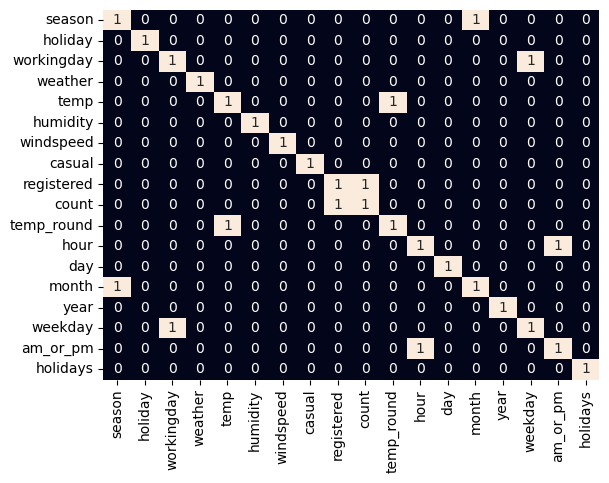

In [140]:
#checking highly correlated data
sns.heatmap(data.corr() > 0.8, 
           annot=True, 
           cbar=False) 
plt.show()

The 'registered' feature is strongly linked to the target variable ('count'), posing a risk of data leakage. To prevent this,  the 'registered' column and the 'time' feature is excluded from our set of features.

In [141]:
#removing outliers found in from above observations humidity and windspeed
data.drop(['registered', 'hour'], axis=1, inplace=True) 
data = data[(data['windspeed'] < 32) & (data['humidity'] > 0)]

In [142]:
data.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,casual,count,temp_round,day,month,year,weekday,am_or_pm,holidays
0,1,0,0,1,9.84,81,0.0,3,16,8.0,1,1,2011,0,0,0
1,1,0,0,1,9.02,80,0.0,8,40,8.0,1,1,2011,0,0,0
2,1,0,0,1,9.02,80,0.0,5,32,8.0,1,1,2011,0,0,0
3,1,0,0,1,9.84,75,0.0,3,13,8.0,1,1,2011,0,0,0
4,1,0,0,1,9.84,75,0.0,0,1,8.0,1,1,2011,0,0,0


Model Training

In [143]:
#splitting training and testing data
features = data.drop(['count'], axis=1) 
target = data['count'].values 
  
X_train, X_val, Y_train, Y_val = train_test_split(features, 
                                                  target, 
                                                  test_size = 0.1, 
                                                  random_state=22) 
X_train.shape, X_val.shape

((9574, 15), (1064, 15))

In [144]:
#Normalizing the data
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_val = scaler.transform(X_val) 

In [35]:
linear_model = LinearRegression()
cv_values = [5, 10, 15, 20]

for cv_value in cv_values:

    kf = KFold(n_splits=cv_value, shuffle=True, random_state=42)
    cross_val_scores = -cross_val_score(linear_model, X_train, Y_train, cv=kf, scoring='neg_mean_absolute_error')

    avg_mae = cross_val_scores.mean()

    print(f'Linear Regression (CV={cv_value}):')
    print('Average Training Error (MAE): ', avg_mae)
    print()
linear_model.fit(X_train, Y_train)

train_preds_linear = linear_model.predict(X_train)
val_preds_linear = linear_model.predict(X_val)

print('Final Training Error: ', mae(Y_train, train_preds_linear))
print('Final Validation Error: ', mae(Y_val, val_preds_linear))

Linear Regression (CV=5):
Average Training Error (MAE):  82.03134657821779

Linear Regression (CV=10):
Average Training Error (MAE):  81.97643827593464

Linear Regression (CV=15):
Average Training Error (MAE):  81.98308603383362

Linear Regression (CV=20):
Average Training Error (MAE):  81.97553737978555

Final Training Error:  81.84336120688737
Final Validation Error:  82.09352450900654


RIDGE

In [37]:
alphas = [0.001, 0.005, 1, 2, 2.5, 3, 3.5, 4, 4.5, 5]
best_alpha = None
best_mean_r2_score = -float('inf')

for alpha in alphas:
    clf1 = Ridge(alpha=alpha)
    r2_scores = cross_val_score(clf1, X_train, Y_train, cv=5, scoring='r2')
    mean_r2 = r2_scores.mean()
    print(f"Alpha: {alpha}, Mean R2 Score: {mean_r2}")

    if mean_r2 > best_mean_r2_score:
        best_mean_r2_score = mean_r2
        best_alpha = alpha

print(f"Best Alpha: {best_alpha}, Best Mean R2 Score: {best_mean_r2_score}")

best_clf1 = Ridge(alpha=best_alpha)
best_clf1.fit(X_train, Y_train)

Alpha: 0.001, Mean R2 Score: 0.5897006035798276
Alpha: 0.005, Mean R2 Score: 0.5897006094281426
Alpha: 1, Mean R2 Score: 0.5897020239824761
Alpha: 2, Mean R2 Score: 0.5897033662519765
Alpha: 2.5, Mean R2 Score: 0.5897040081380044
Alpha: 3, Mean R2 Score: 0.5897046308323924
Alpha: 3.5, Mean R2 Score: 0.5897052345584989
Alpha: 4, Mean R2 Score: 0.5897058195341153
Alpha: 4.5, Mean R2 Score: 0.5897063859716634
Alpha: 5, Mean R2 Score: 0.5897069340783853
Best Alpha: 5, Best Mean R2 Score: 0.5897069340783853


Ridge(alpha=5)

In [38]:
train_preds_Ridge1 = best_clf1.predict(X_train)
val_preds_Ridge1 = best_clf1.predict(X_val)

print('Final Training Error: ', mae(Y_train, train_preds_Ridge1))
print('Final Validation Error: ', mae(Y_val, val_preds_Ridge1))

Final Training Error:  81.97483586554183
Final Validation Error:  82.17653113014873


In [39]:
alphas = [0.001, 0.005, 1, 2, 2.5, 3, 3.5, 4, 4.5, 5]
best_alpha = None
best_mean_r2_score = -float('inf')

for alpha in alphas:
    clf = Ridge(alpha=alpha)
    r2_scores = cross_val_score(clf, X_train, Y_train, cv=10, scoring='r2')
    mean_r2 = r2_scores.mean()
    print(f"Alpha: {alpha}, Mean R2 Score: {mean_r2}")

    if mean_r2 > best_mean_r2_score:
        best_mean_r2_score = mean_r2
        best_alpha = alpha

print(f"Best Alpha: {best_alpha}, Best Mean R2 Score: {best_mean_r2_score}")

best_clf2 = Ridge(alpha=best_alpha)
best_clf2.fit(X_train, Y_train)

Alpha: 0.001, Mean R2 Score: 0.5897131315145183
Alpha: 0.005, Mean R2 Score: 0.5897131398525668
Alpha: 1, Mean R2 Score: 0.5897151705065434
Alpha: 2, Mean R2 Score: 0.5897171257388103
Alpha: 2.5, Mean R2 Score: 0.58971807187046
Alpha: 3, Mean R2 Score: 0.5897189973761631
Alpha: 3.5, Mean R2 Score: 0.5897199025206604
Alpha: 4, Mean R2 Score: 0.5897207875625047
Alpha: 4.5, Mean R2 Score: 0.5897216527542521
Alpha: 5, Mean R2 Score: 0.5897224983426504
Best Alpha: 5, Best Mean R2 Score: 0.5897224983426504


Ridge(alpha=5)

In [40]:
train_preds_Ridge2 = best_clf2.predict(X_train)
val_preds_Ridge2 = best_clf2.predict(X_val)

print('Final Training Error: ', mae(Y_train, train_preds_Ridge2))
print('Final Validation Error: ', mae(Y_val, val_preds_Ridge2))

Final Training Error:  81.97483586554183
Final Validation Error:  82.17653113014873


In [41]:
alphas = [0.001, 0.005, 1, 2, 2.5, 3, 3.5, 4, 4.5, 5]
best_alpha = None
best_mean_r2_score = -float('inf')

for alpha in alphas:
    clf = Ridge(alpha=alpha)
    r2_scores = cross_val_score(clf, X_train, Y_train, cv=15, scoring='r2')
    mean_r2 = r2_scores.mean()
    print(f"Alpha: {alpha}, Mean R2 Score: {mean_r2}")

    if mean_r2 > best_mean_r2_score:
        best_mean_r2_score = mean_r2
        best_alpha = alpha

print(f"Best Alpha: {best_alpha}, Best Mean R2 Score: {best_mean_r2_score}")

best_clf3 = Ridge(alpha=best_alpha)
best_clf3.fit(X_train, Y_train)

Alpha: 0.001, Mean R2 Score: 0.5895145179126016
Alpha: 0.005, Mean R2 Score: 0.58951452517517
Alpha: 1, Mean R2 Score: 0.5895162924817673
Alpha: 2, Mean R2 Score: 0.5895179912436724
Alpha: 2.5, Mean R2 Score: 0.5895188121390783
Alpha: 3, Mean R2 Score: 0.5895196143649383
Alpha: 3.5, Mean R2 Score: 0.5895203981549808
Alpha: 4, Mean R2 Score: 0.5895211637376275
Alpha: 4.5, Mean R2 Score: 0.5895219113361548
Alpha: 5, Mean R2 Score: 0.5895226411688469
Best Alpha: 5, Best Mean R2 Score: 0.5895226411688469


Ridge(alpha=5)

In [42]:
train_preds_Ridge3 = best_clf3.predict(X_train)
val_preds_Ridge3 = best_clf3.predict(X_val)

print('Final Training Error: ', mae(Y_train, train_preds_Ridge3))
print('Final Validation Error: ', mae(Y_val, val_preds_Ridge3))

Final Training Error:  81.97483586554183
Final Validation Error:  82.17653113014873


LASSO 

In [43]:
alpha_values = [0.001, 0.01, 0.1, 1, 2, 2.5, 3, 3.5, 4, 4.5, 5]

best_alpha = None
best_r2_score = -float('inf')
best_lasso_model = None

for alpha in alpha_values:
    lasso = Lasso(alpha=alpha)
    r2_scores = cross_val_score(lasso, X_train, Y_train, cv=5, scoring='r2')  # Adjust cv as needed
    mean_r2 = r2_scores.mean()

    print(f"Alpha: {alpha}, Mean R2 Score: {mean_r2}")

    if mean_r2 > best_r2_score:
        best_r2_score = mean_r2
        best_alpha = alpha
        best_lasso_model = lasso

print(f"Best Alpha: {best_alpha}, Best Mean R2 Score: {best_r2_score}")
best_lasso1 = Lasso(alpha=best_alpha)
best_lasso1.fit(X_train, Y_train)

Alpha: 0.001, Mean R2 Score: 0.5897007188721094
Alpha: 0.01, Mean R2 Score: 0.5897009682849521
Alpha: 0.1, Mean R2 Score: 0.5896791337072683
Alpha: 1, Mean R2 Score: 0.5896787432598736
Alpha: 2, Mean R2 Score: 0.5891587577293504
Alpha: 2.5, Mean R2 Score: 0.5887422530712323
Alpha: 3, Mean R2 Score: 0.5882099329806785
Alpha: 3.5, Mean R2 Score: 0.5875799984254958
Alpha: 4, Mean R2 Score: 0.5868978824840371
Alpha: 4.5, Mean R2 Score: 0.5861643229428867
Alpha: 5, Mean R2 Score: 0.5853393594138762
Best Alpha: 0.01, Best Mean R2 Score: 0.5897009682849521


Lasso(alpha=0.01)

In [44]:
train_preds_lasso1 = best_lasso1.predict(X_train)
val_preds_lasso1 = best_lasso1.predict(X_val)

print('Final Training Error: ', mae(Y_train, train_preds_lasso1))
print('Final Validation Error: ', mae(Y_val, val_preds_lasso1))

Final Training Error:  81.9771401160898
Final Validation Error:  82.17371695642399


In [45]:
alpha_values = [0.001, 0.01, 0.1, 1, 2, 2.5, 3, 3.5, 4, 4.5, 5]

best_alpha = None
best_r2_score = -float('inf')
best_lasso_model = None

for alpha in alpha_values:
    lasso = Lasso(alpha=alpha)
    r2_scores = cross_val_score(lasso, X_train, Y_train, cv=10, scoring='r2')  # Adjust cv as needed
    mean_r2 = r2_scores.mean()

    print(f"Alpha: {alpha}, Mean R2 Score: {mean_r2}")

    if mean_r2 > best_r2_score:
        best_r2_score = mean_r2
        best_alpha = alpha
        best_lasso_model = lasso

print(f"Best Alpha: {best_alpha}, Best Mean R2 Score: {best_r2_score}")
best_lasso2 = Lasso(alpha=best_alpha)
best_lasso2.fit(X_train, Y_train)

Alpha: 0.001, Mean R2 Score: 0.5897132261631326
Alpha: 0.01, Mean R2 Score: 0.589713293839921
Alpha: 0.1, Mean R2 Score: 0.589782041207578
Alpha: 1, Mean R2 Score: 0.589713224957878
Alpha: 2, Mean R2 Score: 0.5892196356753565
Alpha: 2.5, Mean R2 Score: 0.5888004309587969
Alpha: 3, Mean R2 Score: 0.5882699527517654
Alpha: 3.5, Mean R2 Score: 0.5876419746444579
Alpha: 4, Mean R2 Score: 0.5869158702557217
Alpha: 4.5, Mean R2 Score: 0.5861057952459985
Alpha: 5, Mean R2 Score: 0.5852715277344694
Best Alpha: 0.1, Best Mean R2 Score: 0.589782041207578


Lasso(alpha=0.1)

In [46]:
train_preds_lasso2 = best_lasso2.predict(X_train)
val_preds_lasso2 = best_lasso2.predict(X_val)

print('Final Training Error: ', mae(Y_train, train_preds_lasso2))
print('Final Validation Error: ', mae(Y_val, val_preds_lasso2))

Final Training Error:  81.94436277829806
Final Validation Error:  82.11946478188486


In [47]:
alpha_values = [0.001, 0.01, 0.1, 1, 2, 2.5, 3, 3.5, 4, 4.5, 5]

best_alpha = None
best_r2_score = -float('inf')
best_lasso_model = None

for alpha in alpha_values:
    lasso = Lasso(alpha=alpha)
    r2_scores = cross_val_score(lasso, X_train, Y_train, cv=15, scoring='r2')  # Adjust cv as needed
    mean_r2 = r2_scores.mean()

    print(f"Alpha: {alpha}, Mean R2 Score: {mean_r2}")

    if mean_r2 > best_r2_score:
        best_r2_score = mean_r2
        best_alpha = alpha
        best_lasso_model = lasso

print(f"Best Alpha: {best_alpha}, Best Mean R2 Score: {best_r2_score}")
best_lasso3 = Lasso(alpha=best_alpha)
best_lasso3.fit(X_train, Y_train)

Alpha: 0.001, Mean R2 Score: 0.5895146751720955
Alpha: 0.01, Mean R2 Score: 0.5895153025101133
Alpha: 0.1, Mean R2 Score: 0.5895741769200569
Alpha: 1, Mean R2 Score: 0.5894685247349116
Alpha: 2, Mean R2 Score: 0.5890047766025962
Alpha: 2.5, Mean R2 Score: 0.5885800185207277
Alpha: 3, Mean R2 Score: 0.588055323878395
Alpha: 3.5, Mean R2 Score: 0.5874325215139699
Alpha: 4, Mean R2 Score: 0.5867120730512071
Alpha: 4.5, Mean R2 Score: 0.5858988418427205
Alpha: 5, Mean R2 Score: 0.5850821785492272
Best Alpha: 0.1, Best Mean R2 Score: 0.5895741769200569


Lasso(alpha=0.1)

In [48]:
train_preds_lasso3 = best_lasso3.predict(X_train)
val_preds_lasso3 = best_lasso3.predict(X_val)

print('Final Training Error: ', mae(Y_train, train_preds_lasso3))
print('Final Validation Error: ', mae(Y_val, val_preds_lasso3))

Final Training Error:  81.94436277829806
Final Validation Error:  82.11946478188486


If the risk of overfitting is a consideration, it may be preferable to opt for simpler models such as Linear, Ridge, or Lasso regression. These models exhibit a favorable trade-off between training and validation errors, indicating a more balanced performance across the dataset.

RANDOM FOREST

In [49]:
#Random Forest
rf1 = RandomForestRegressor(n_estimators = 100, max_features = 'sqrt', max_depth = 5, random_state = 42).fit(X_train, Y_train)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_values = cross_val_score(rf1, X_train, Y_train, cv=kf, scoring='r2')
mean_r2 = np.mean(r2_values)
print(f"Mean R-squared Score: {mean_r2}")

Mean R-squared Score: 0.591716080091999


In [50]:
train_preds_rf1 = rf1.predict(X_train)
val_preds_rf1 = rf1.predict(X_val)

print('Final Training Error: ', mae(Y_train, train_preds_rf1))
print('Final Validation Error: ', mae(Y_val, val_preds_rf1))

Final Training Error:  81.86887894033096
Final Validation Error:  82.60803413585876


In [51]:
#Random Forest
rf2 = RandomForestRegressor(n_estimators = 200, max_features = 'sqrt', max_depth = 5, random_state = 42).fit(X_train, Y_train)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_values = cross_val_score(rf2, X_train, Y_train, cv=kf, scoring='r2')
mean_r2 = np.mean(r2_values)
print(f"Mean R-squared Score: {mean_r2}")

Mean R-squared Score: 0.5900377360765633


In [52]:
train_preds_rf2 = rf2.predict(X_train)
val_preds_rf2 = rf2.predict(X_val)

print('Final Training Error: ', mae(Y_train, train_preds_rf2))
print('Final Validation Error: ', mae(Y_val, val_preds_rf2))

Final Training Error:  82.3457541394222
Final Validation Error:  83.27157163680809


In [53]:
#Random Forest
rf3 = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 42).fit(X_train, Y_train)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_values = cross_val_score(rf3, X_train, Y_train, cv=kf, scoring='r2')
mean_r2 = np.mean(r2_values)
print(f"Mean R-squared Score: {mean_r2}")

Mean R-squared Score: 0.5892958873091575


In [54]:
train_preds_rf3 = rf3.predict(X_train)
val_preds_rf3 = rf3.predict(X_val)

print('Final Training Error: ', mae(Y_train, train_preds_rf3))
print('Final Validation Error: ', mae(Y_val, val_preds_rf3))

Final Training Error:  82.56261039215403
Final Validation Error:  83.36449440716751


In [55]:
r_squared_scores = [0.591716080091999,0.5900377360765633, 0.5892958873091575]

mean_r_squared = np.mean(r_squared_scores)

# Calculate bias-squared and variance
bias_squared = np.mean((r_squared_scores - mean_r_squared) ** 2)
variance = np.var(r_squared_scores)

print(f"Mean R-squared Score: {mean_r_squared}")
print(f"Bias-Squared: {bias_squared}")
print(f"Variance: {variance}")

Mean R-squared Score: 0.5903499011592399
Bias-Squared: 1.0249457037743217e-06
Variance: 1.0249457037743217e-06


In [56]:
from sklearn.metrics import accuracy_score
C_values = [0.1,0.2,0.3,0.5,0.7,1.0,1.5,2.0,2.5,5.0,7.5,10.0, 100.0]

for C_value in C_values:
    svm_classifier = SVC(kernel='linear', C=C_value)
    svm_classifier.fit(X_train, Y_train)
    svm_predictions = svm_classifier.predict(X_val)
    accuracy = accuracy_score(Y_val, svm_predictions)
    print(f"Accuracy (C={C_value}): {accuracy}")

Accuracy (C=0.1): 0.015037593984962405
Accuracy (C=0.2): 0.015037593984962405
Accuracy (C=0.3): 0.015037593984962405
Accuracy (C=0.5): 0.013157894736842105
Accuracy (C=0.7): 0.017857142857142856
Accuracy (C=1.0): 0.017857142857142856
Accuracy (C=1.5): 0.016917293233082706
Accuracy (C=2.0): 0.015977443609022556
Accuracy (C=2.5): 0.015977443609022556
Accuracy (C=5.0): 0.017857142857142856
Accuracy (C=7.5): 0.020676691729323307
Accuracy (C=10.0): 0.02537593984962406
Accuracy (C=100.0): 0.023496240601503758


BEST MODEL: C=10.0 Accuracy=0.02537593984962406

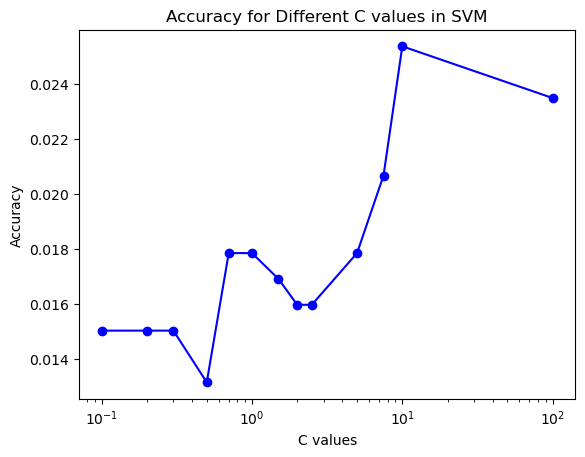

In [58]:
C_values = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 5.0, 7.5, 10.0, 100.0]
accuracies = [0.015037593984962405, 0.015037593984962405, 0.015037593984962405, 0.013157894736842105,
              0.017857142857142856, 0.017857142857142856, 0.016917293233082706, 0.015977443609022556,
              0.015977443609022556, 0.017857142857142856, 0.020676691729323307, 0.02537593984962406,
              0.023496240601503758]

# Create a line plot
plt.plot(C_values, accuracies, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Use log scale for better visualization if C values are on a wide range
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different C values in SVM')
plt.show()

In [59]:
svm = SVC(kernel='linear', C=10)
svm.fit(X_train, Y_train)
accuracy = accuracy_score(Y_val, svm_predictions)
print(f"Accuracy (C={C_value}): {accuracy}")
train_preds_svm = svm.predict(X_train)
val_preds_svm = svm.predict(X_val)

print('Final Training Error: ', mae(Y_train, train_preds_svm))
print('Final Validation Error: ', mae(Y_val, val_preds_svm))

Accuracy (C=100.0): 0.023496240601503758
Final Training Error:  63.09233340296637
Final Validation Error:  91.57894736842105


SVM seems to overfit the training data, and its high validation error suggests that it may not generalize well to new, unseen data.

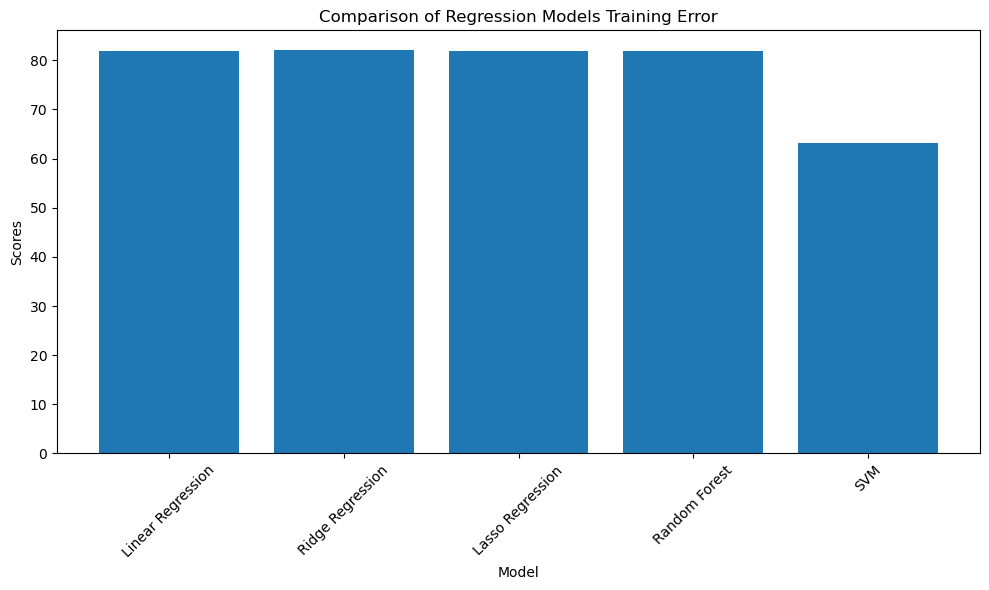

In [151]:
import matplotlib.pyplot as plt

linear_regression_value = 81.84336120688737
ridge_regression_value = 81.97483586554183
lasso_regression_value = 81.94436277829806
Random_forest = 81.86887894033096
svm_value = 63.09233340296637

models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'SVM']
scores = [linear_regression_value, ridge_regression_value, lasso_regression_value, Random_forest, svm_value]

plt.figure(figsize=(10, 6))
plt.bar(models, scores)
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Models Training Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


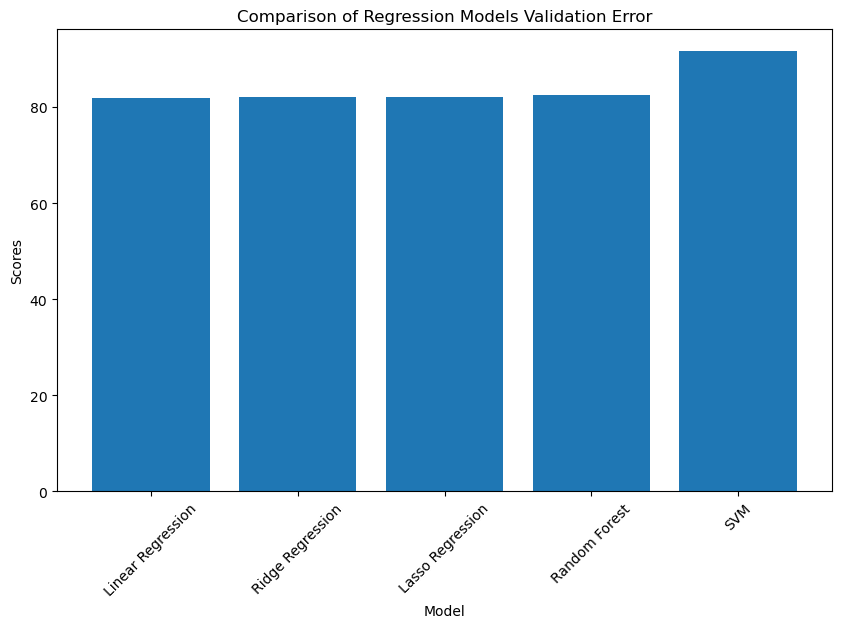

In [150]:
import matplotlib.pyplot as plt

linear_regression_value = 81.84336120688737
ridge_regression_value = 82.17653113014873
lasso_regression_value = 82.11946478188486
Random_forest = 82.60803413585876
svm_value = 91.57894736842105

models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'SVM']
scores = [linear_regression_value, ridge_regression_value, lasso_regression_value, Random_forest, svm_value]

plt.figure(figsize=(10, 6))
plt.bar(models, scores)
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Models Validation Error')
plt.xticks(rotation=45)
plt.show()


The Random Forest model demonstrates competitive performance with a training error of 81.87 and a validation error of 82.61. While the training error is slightly higher than some other models, the validation error suggests that the model generalizes well to unseen data. Random Forests are known for their ability to handle complex relationships in data and mitigate overfitting. In this case, the model seems to strike a good balance between complexity and generalization. Consider the Random Forest model as a robust option for your regression task, particularly if a slightly more complex model is acceptable. Regular monitoring and potential fine-tuning of hyperparameters can further optimize its performance.

In [145]:
#Random Forest
rf1 = RandomForestRegressor(n_estimators = 100, max_features = 'sqrt', max_depth = 5, random_state = 42).fit(X_train, Y_train)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rf1_pred=rf1.predict(X_val)
rf1_pred

array([298.96846577, 193.51830871, 210.06016809, ..., 246.4723394 ,
       294.97580268, 444.81273522])

In [149]:
importances = rf1.feature_importances_
importances

array([2.35893413e-02, 3.43788321e-04, 7.75308835e-03, 4.79675638e-03,
       7.70291550e-02, 6.08419780e-02, 7.36768276e-03, 5.01542999e-01,
       7.71632731e-02, 1.90899442e-03, 2.54499413e-02, 7.19498827e-02,
       7.05909530e-03, 1.33012035e-01, 1.91989029e-04])

In [161]:
features = data.drop(['count'], axis=1) 

In [162]:
importances = rf1.feature_importances_
feature_names = features.columns

feature_importance_dict = dict(zip(feature_names, importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


casual: 0.5015429987791681
am_or_pm: 0.13301203529250158
temp_round: 0.0771632731034272
temp: 0.07702915501523024
year: 0.07194988269661794
humidity: 0.06084197799294106
month: 0.025449941278616984
season: 0.0235893412765925
workingday: 0.007753088350607658
windspeed: 0.007367682762913773
weekday: 0.00705909529510345
weather: 0.004796756383343192
day: 0.0019089944233760309
holiday: 0.0003437883208636397
holidays: 0.00019198902869666738


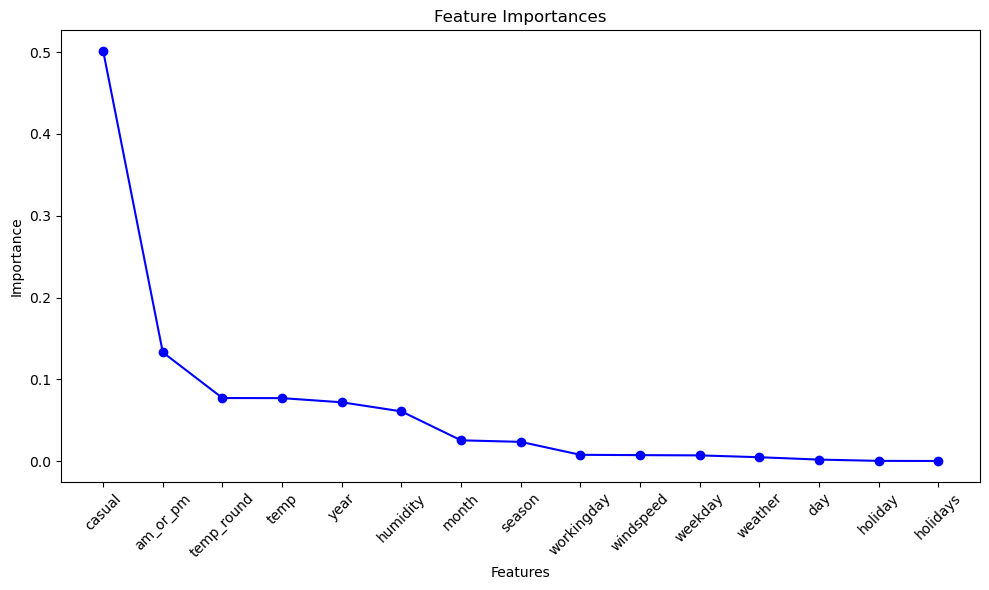

In [163]:
features, importances = zip(*sorted_feature_importance)

plt.figure(figsize=(10, 6))
plt.plot(features, importances, marker='o', linestyle='-', color='b')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()